In [25]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

Data augumentation + dataloaders creation

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/hymenoptera_data-20250206T082412Z-001/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image Vis

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)





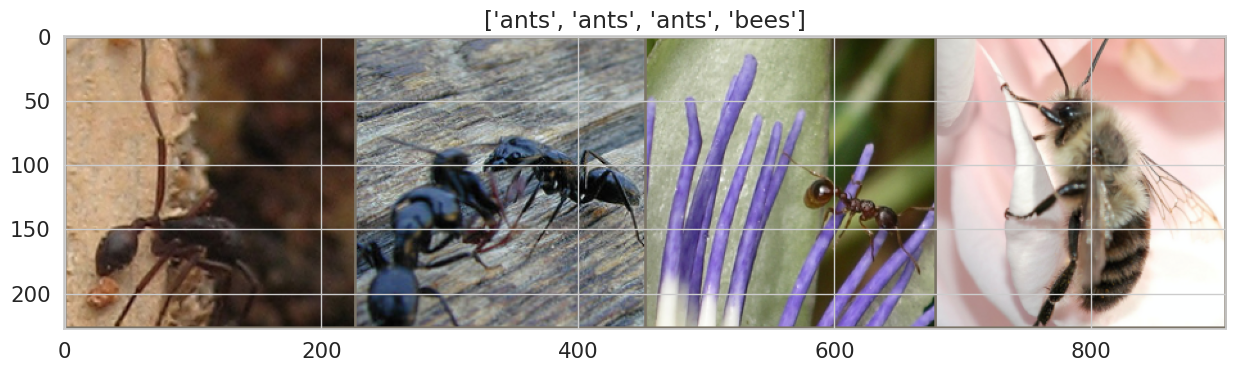

In [28]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "val": []}
    pbar = trange(num_epochs, desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels
                if phase=="train":
                    optimizer.zero_grad()
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            losses[phase].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, losses

In [30]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [31]:
def evaluate(model):
    model.eval()

    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

In [32]:
torch.cuda.is_available()

True

In [33]:
model = models.vgg16(pretrained=True)


In [34]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)



if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 4m 12s
Best val Acc: 0.947712


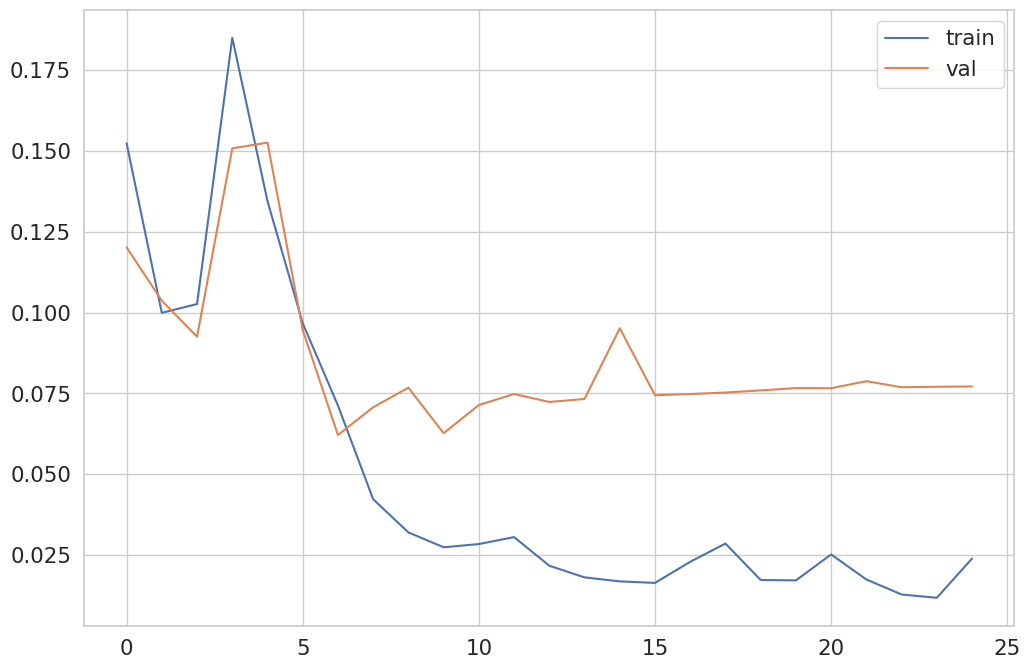

In [38]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [40]:
# Save the fine-tuned VGG model
torch.save(model.state_dict(), 'VGG16_fine_tune.pth')

# Later, load the model state
model.load_state_dict(torch.load('VGG16_fine_tune.pth'))

# Evaluate the model
print("Accuracy: {0:.4f}".format(evaluate(model)))


<ipython-input-40-b597b651dd1e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('VGG16_fine_tune.pth'))


Accuracy: 0.9477


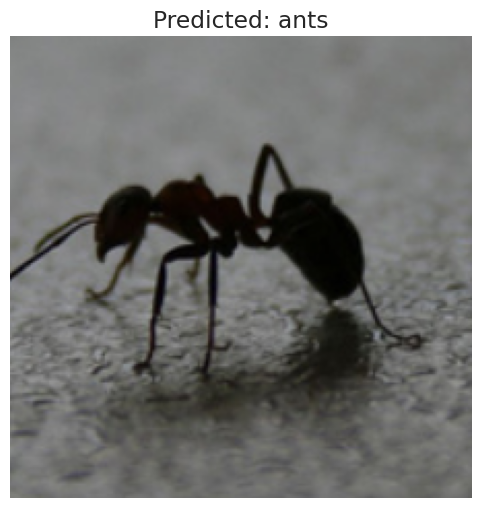

Predicted class from test data: ants


In [42]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def predict_from_test_data(model, dataloader, class_names, device=None):
    """
    Takes a single image from the dataloader, predicts its class, and displays the image.

    Args:
        model (torch.nn.Module): Trained model.
        dataloader (DataLoader): Dataloader for test/validation data.
        class_names (list): List of class names corresponding to model outputs.
        device (torch.device or str, optional): Device to run prediction on.
            Defaults to "cuda" if available.

    Returns:
        predicted_class (str): The predicted class label.
    """
    # Set device if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get one batch from the dataloader and pick the first image
    model.eval()  # set model to evaluation mode
    inputs, labels = next(iter(dataloader))

    # Move image to the proper device
    input_img = inputs[0].unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_img)
        _, predicted_idx = torch.max(outputs, 1)

    predicted_class = class_names[predicted_idx.item()]

    # Display the image along with the prediction
    # Denormalize the image for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_to_show = inv_normalize(inputs[0]).cpu().numpy().transpose((1, 2, 0))
    img_to_show = np.clip(img_to_show, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_to_show)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

# Example usage:
predicted_label = predict_from_test_data(model, dataloaders['val'], class_names)
print("Predicted class from test data:", predicted_label)
